In [1]:
import os, os.path
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.pyplot
import gym
import copy
import sys

In [2]:
class ReplayBuffer:
    def __init__(self, capacity=1e4):
        self.cap = capacity
        self.buffer = []
        self.pos = 0
    
    def add(self, o, a, r, o2, d):
        exp = [o, a, r, o2, d]

        if len(self.buffer) < self.cap:
            self.buffer.append(exp)
        else:
            self.buffer[int(self.pos)] = exp
            self.pos = (int(self.pos) + 1) % self.cap
    
    def sample(self, batch_size=32):
        batch = random.sample(self.buffer, batch_size)
        obs, action, reward, next_obs, done = map(np.stack, zip(*batch))
        return obs, action, reward, next_obs, done
    
    def __len__(self):
        return len(self.buffer)
    
class Actor(nn.Module):
    def __init__(self, obs_space, action_space, hidden_size=128):
        super(Actor, self).__init__()
        
        if type(obs_space) == gym.spaces.Box:
            self.obs_dim = obs_space.shape[0]
        else:
            self.obs_dim = obs_space.n
            
        # Set dimensions of actor layers
        self.fc1 = nn.Linear(self.obs_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, action_space.shape[0])
        #self.loss = nn.MSELoss()
        self.loss = nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.parameters())
    
    # Take an action based on epsilon greedy policy
    def forward(self, obs):
        temp = F.relu(self.fc1(obs))
        temp = F.relu(self.fc2(temp))
        temp = F.relu(self.fc3(temp))
        temp = F.relu(self.fc4(temp))
        action = torch.tanh(self.out(temp))
        return action


class Critic(nn.Module):
    def __init__(self, obs_space, action_space, hidden_size=128):
        super(Critic, self).__init__()
        
        if type(obs_space) == gym.spaces.Box:
            self.obs_dim = obs_space.shape[0]
        else:
            self.obs_dim = obs_space.n
            
        self.action_dim = action_space.shape[0]
            
        # Set dimensions of critic layers
        self.fc1 = nn.Linear(self.obs_dim + self.action_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        #self.loss = nn.MSELoss()
        self.loss = nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.parameters())
    
    # Take an action based on epsilon greedy policy
    def forward(self, obs, action):
        temp = F.relu(self.fc1(torch.cat([obs, action], dim=1)))
        temp = F.relu(self.fc2(temp))
        temp = F.relu(self.fc3(temp))
        temp = F.relu(self.fc4(temp))
        q_value = self.out(temp)
        return q_value
        
def plot(frame_idx, rewards, losses, epsilon_vals):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Episode %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('Loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title('Epsilon')
    plt.plot(epsilon_vals)
    plt.show()


    
#env = gym.make('Acrobot-v1')

# Takes an action from the Actor network (each action is in the space [-1, 1])
# and maps it to the action space of the environment
def wrap_action(env, action):
    low = env.action_space.low
    high = env.action_space.high
    
    new_action = low + (action + 1)/2 * (high - low)
    return np.clip(new_action, low, high)

#print('Obs Space:', env.observation_space)
#print('Action Space:', env.action_space.n)

In [3]:
import jackal_envs

env = gym.make('jackal_navigation-v0', world_name = 'sequential_applr_testbed', gui = 'false', VLP16 = 'false', init_position = [45, 1, 0], goal_position = [-4.2, .16, 0])

Launching odom process


Waiting for service /move_base/TrajectoryPlannerROS/set_parameters...
/home/gauraang/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/gauraang/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


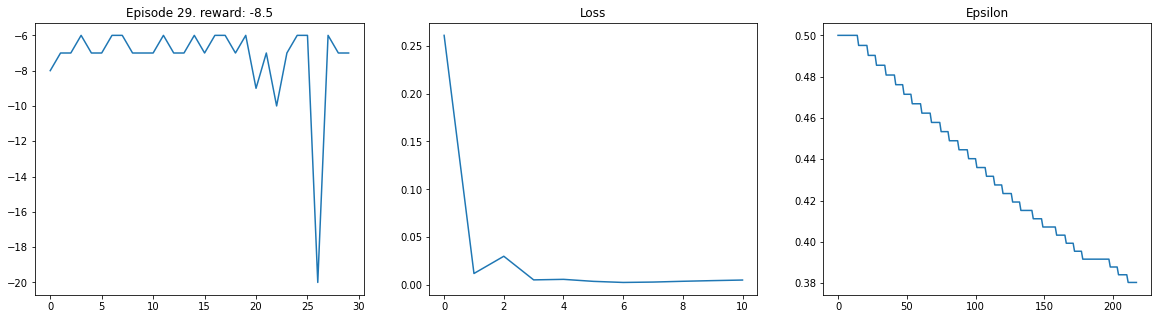

In [4]:
import jackal_envs

def train(env, device, episodes=30, \
          max_steps=float('inf'), alpha=0.2, gamma=0.95, epsilon=0.5, target_noise=0.05, buffer_cap=1e4, \
          polyak=0.99, batch_size=128, iterations=1):

    q_net1 = Critic(env.observation_space, env.action_space).to(device)
    q_net2 = Critic(env.observation_space, env.action_space).to(device)
    
    replay_buffer = ReplayBuffer(capacity=buffer_cap)

    target_qnet1 = copy.deepcopy(q_net1).to(device)
    target_qnet2 = copy.deepcopy(q_net2).to(device)

    policy_net = Actor(env.observation_space, env.action_space).to(device)
    target_policy_net = copy.deepcopy(policy_net).to(device)

    rewards = []
    losses = []
    min_epsilon = 0.01
    max_epsilon = 0.5
    decay_rate = 0.01
    # Update policy every 2 steps
    POLICY_UPDATE = 2
    # Bounds for the exploration noise
    noise_lower_bound = -0.5
    noise_upper_bound = 0.5
    
    # Used to add noise to the target action - smooth out changes in action 
    # to avoid exploiting Q approximation errors
    target_noise = target_noise
    epsilon_vals = []
    
    # Make sure target network gradients aren't calculated
    for param in target_qnet1.parameters():
        param.requires_grad = False
        
    for param in target_qnet2.parameters():
        param.requires_grad = False


    for param in target_policy_net.parameters():
        param.requires_grad = False

    for ep in range(episodes):
        o = env.reset()
        d = False
        steps = 0
        cum_reward = 0
        
        while not d:
            # Send obs to network and take action
            explore = np.random.rand() <= epsilon
            a = None
            epsilon_vals.append(epsilon)
            # Add clipped noise to the action for exploration
            with torch.no_grad():
                obs = torch.cuda.FloatTensor(o)
                a = policy_net(obs).cpu().detach().numpy() + np.clip(np.random.randn() * epsilon, noise_lower_bound,\
                                                                     noise_upper_bound)
                a = np.clip(a, -1, 1)
            o2, r, d, _ = env.step(a)
            # Add experience to replay buffer
            replay_buffer.add(o, a, r, o2, d)

            # Update network if buffer capacity >= batch_size
            if len(replay_buffer) >= batch_size:
                # Sample a batch of experiences
                for i in range(iterations):
                    obs, action, reward, next_obs, done = replay_buffer.sample(batch_size)
                    obs = torch.cuda.FloatTensor(obs).to(device)
                    action = torch.cuda.FloatTensor(action).to(device)
                    reward = torch.cuda.FloatTensor(reward).to(device)
                    next_obs = torch.cuda.FloatTensor(next_obs).to(device)
                    done = torch.cuda.FloatTensor(done).to(device)

                    # Calculate the TD(0) update step
                    target = None
                    with torch.no_grad():
                        # Calculate the next action using the target policy
                        next_action = target_policy_net(next_obs).detach()
                        # Add noise to target action for policy smoothing
                        target_noise = torch.randn_like(next_action) * target_noise                                              
                        next_action += target_noise
                        # Clip target action within tanh bounds
                        next_action = torch.where(next_action < torch.tensor(-1.),\
                                                  torch.tensor(-1.).to(device), next_action)
                        next_action = torch.where(next_action > torch.tensor(1),\
                          torch.tensor(1.).to(device), next_action)
                        
                        # Double Q-Learning - Use minimum target q value
                        next_q_values = torch.min(target_qnet1(next_obs, next_action), \
                                                  target_qnet2(next_obs, next_action))
                        target = reward + (1 - done) * gamma * \
                            next_q_values.squeeze(1)
                                        
                    q_pred1 = q_net1(obs, action).squeeze(1)
                    td_error1 = q_net1.loss(q_pred1, target)
                    
                    q_pred2 = q_net2(obs, action).squeeze(1)
                    td_error2 = q_net2.loss(q_pred2, target)

                    # Zero out optimizers and calculate critic gradients
                    q_net1.optimizer.zero_grad()
                    td_error1.backward()

                    q_net2.optimizer.zero_grad()
                    td_error2.backward()

                    # Update critics
                    for param in q_net1.parameters():
                        param.grad.data.clamp_(-1, 1)
                    q_net1.optimizer.step()
                                              
                    for param in q_net2.parameters():
                        param.grad.data.clamp_(-1, 1)
                    q_net2.optimizer.step()
                    
                    
                    # Update Policy net
                    policy_actions = policy_net(obs)
                    
                    # Use the critic with a lower q value
                    q_pi = -1 * torch.min(target_qnet1(obs, policy_actions), target_qnet2(obs, policy_actions))
                    # Encourage policy net to take action that maximizes Q values
                    policy_net.optimizer.zero_grad()
                    q_pi.mean().backward()
                    policy_net.optimizer.step()

                    # Update the targets critic network every step
                    with torch.no_grad():
                        for critic_param, target_param in zip(q_net1.parameters(), target_qnet1.parameters()):
                            target_param.mul_(polyak)
                            target_param.add_((1 - polyak) * critic_param)
                                              
                    with torch.no_grad():
                        for critic_param, target_param in zip(q_net2.parameters(), target_qnet2.parameters()):
                            target_param.mul_(polyak)
                            target_param.add_((1 - polyak) * critic_param)

                    # Update the target policy network every other step
                    if steps % POLICY_UPDATE == 0:
                        with torch.no_grad():
                            for policy_param, target_param in zip(policy_net.parameters(), target_policy_net.parameters()):
                                target_param.mul_(polyak)
                                target_param.add_((1 - polyak) * policy_param)

                    
                    if d:
                        losses.append(torch.min(td_error1, td_error2).item())


            # Don't forget to update observation sent to network!!!
            o = o2
            
            # Update variables
            steps += 1
            cum_reward += r
        
        # Decay epsilon
        epsilon = min_epsilon + (max_epsilon - min_epsilon)\
            *np.exp(-decay_rate*ep)    
        
        rewards.append(cum_reward)
        # Plot
        plot(ep, rewards, losses, epsilon_vals)
    return policy_net, rewards

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

agent, rewards = train(env, device)

In [5]:
import time
import jackal_envs

def test(env, device, agent, episodes=10):
    print('Starting tests')
    for ep in range(episodes):
        d = False
        steps = 0
        o = env.reset()
        total = 0
        print('Episode:', ep)
        while not d:
            # Take Action
            obs = torch.cuda.FloatTensor(o).to(device)
            a = agent(obs).cpu().detach().numpy()
            # Progress Environment
            o2, r, d, _ = env.step(a)
            total += r
            steps += 1
        print('Reward:', total)

agent = Actor(env.observation_space, env.action_space).to(device)
agent.load_state_dict(torch.load('./zoo/sequential_jackal_env.pt'))
#env = gym.make('jackal_navigation-v0', world_name = 'sequential_applr_testbed', gui = 'true', VLP16 = 'false', init_position = [45, 1, 0], goal_position = [-4.2, .16, 0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(env, device, agent)

Starting tests
Episode: 0
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
REACHED GOAL!!!
Reward: -7
Episode: 1
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
REACHED GOAL!!!
Reward: -6
Episode: 2
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003, 12.0, 8.0, 1.5, 2.0]
Action: [2.0, 3.1400003,

In [5]:
import jackal_envs
done = False
count = 0
#env = gym.make('jackal_navigation-v0', world_name = 'sequential_applr_testbed', gui = 'false', VLP16 = 'false', init_position = [45, 1, 0], goal_position = [-4.2, .16, 0])
env.reset()
steps = 100
while not done and count < steps:
    count += 1
    obs, rew, done, _ = env.step(env.action_space.sample(), sampled=True)
    print('current step %d' %(count))

print(env.gazebo_sim.get_model_state())
print('Done!!!!')

Launching odom process


/home/gauraang/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/gauraang/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Action: [1.8348445, 2.9971733, 56.0, 162.0, 0.96538466, 1.520796]
current step 1
Action: [1.6865104, 5.888501, 45.0, 378.0, 1.1137725, 2.1001043]
current step 2
Action: [2.1633437, 4.0614843, 48.0, 207.0, 1.0191343, 2.744075]
current step 3
Action: [2.1170425, 2.3770108, 27.0, 322.0, 1.1959106, 1.502668]
current step 4
Action: [1.2865537, 2.9471078, 46.0, 625.0, 1.8202794, 2.064444]
current step 5
Action: [1.365615, 5.240943, 37.0, 623.0, 1.2353339, 1.980492]
current step 6
Action: [1.9050447, 4.334442, 47.0, 219.0, 1.2670696, 1.8097018]
current step 7
Action: [1.2019638, 5.2924705, 43.0, 277.0, 1.2051064, 2.8432238]
current step 8
Action: [2.0971892, 2.281599, 27.0, 575.0, 1.1973418, 2.8964703]
current step 9
Action: [2.0887072, 2.9489722, 26.0, 186.0, 0.93670356, 1.3920629]
current step 10
Action: [1.6008264, 5.248359, 56.0, 293.0, 1.7669432, 1.9181741]
current step 11
Action: [2.4464135, 3.9031353, 46.0, 308.0, 1.019196, 2.050355]
current step 12
Action: [2.51948, 3.053535, 27.0, 57

In [9]:
os.makedirs('./zoo', exist_ok=True)
torch.save(agent.state_dict(), './zoo/sequential_jackal_env.pt')